In [1]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random
import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report
from keras_preprocessing.text import tokenizer_from_json

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec, FastText
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle


D:\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
embeddings = ["w2v", "ft"]
embedding = embeddings[1]

<b>Choose a project among Chrome and Linux or the full dataset</b>

In [4]:
#data = pd.read_csv(os.path.join('..','data', 'full_data_reduced.csv'))
#data = pd.read_csv(os.path.join('..','data', 'chrome_data_reduced.csv'))
data = pd.read_csv(os.path.join('..','data', 'linux_data_reduced.csv'))

<b>Shuffle the dataset before starting operating on it</b>

In [5]:
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)
#data = data.iloc[0:1000]

In [6]:
print(data.head())

                                                func  vul  length
0  static inline void __ap_schedule_poll_timer(vo...    0      30
1  static int sctp_autobind(struct sock *sk)\n{\n...    0      36
2  static ssize_t ucma_init_qp_attr(struct ucma_f...    0      88
3  static void __blk_mq_requeue_request(struct re...    0      24
4  static void vhost_net_flush(struct vhost_net *...    0      37


In [7]:
np.max(data["length"])

237

In [8]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)


Maximum number of words: 237


In [9]:
vc = data["vul"].value_counts()

print(vc)

print("Vulnerability Percentage: ", (vc[1] / vc[0])*100, '%')

0    43024
1     1439
Name: vul, dtype: int64
Vulnerability Percentage:  3.344644849386389 %


<b>PRE_PROCESSING</b>

In [10]:
nltk.download('punkt')

tokenized_list = [word_tokenize(sentence) for sentence in data["func"].tolist()]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iliaskaloup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<b>Train-val-test split</b>

In [11]:
# split data into train and test and then train into train and val (90% train, 10% test and then 90% train and 20% val)
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

x_train_val, x_test, y_train_val, y_test = train_test_split(tokenized_list, data["vul"].tolist(), stratify = data["vul"].tolist(), test_size=0.1, random_state=shuffle_seeder)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, test_size=0.1, random_state=shuffle_seeder)


<b>Train word embeddings</b>

In [12]:
def vectorize(word_model, words, dim):
    words_vecs = [word_model.wv[word] for word in words if word in word_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(dim)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [13]:
dim = 100
methods = ["w2v", "fastText"]
method = methods[0]

if method == "w2v":
    word_model = Word2Vec(x_train, vector_size=dim, window=20, workers=4, epochs=2, min_count=1) # , sg=1
elif method == "fastText":
    word_model = FastText(x_train, vector_size=dim, window=20, workers=4, epochs=2, min_count=1)

#create sentence-level vectors
x_train_val = np.array([vectorize(word_model, sentence, dim) for sentence in x_train_val])
x_train = np.array([vectorize(word_model, sentence, dim) for sentence in x_train])
x_test = np.array([vectorize(word_model, sentence, dim) for sentence in x_test])
x_val = np.array([vectorize(word_model, sentence, dim) for sentence in x_val])

In [14]:
# Convert labels to integers
y_train_val = [int(label) for label in y_train_val]
y_test = [int(label) for label in y_test]
y_train = [int(label) for label in y_train]
y_val = [int(label) for label in y_val]

<b>Handling imbalanced data</b>

Class weighting

In [15]:
#total observations / (number of classes * observations in class)
class_weights = {0:len(data) / (len(vc) * vc[0]), 1:len(data) / (len(vc) * vc[1])}
#class_weights = {0:1, 1:1}
class_weights

{0: 0.516723224246932, 1: 15.449270326615705}

Under-sampling of the clean samples

In [16]:
# Apply under-sampling with the specified strategy
class_counts = pd.Series(y_train).value_counts()
print("Class distribution ", class_counts)
majority_class = class_counts.idxmax()
print("Majority class ", majority_class)
target_count = int(class_counts.iloc[0] / 2) 
print("Targeted number of majority class", target_count)

# under
sampling_strategy = {majority_class: target_count}        
rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train) 
print("Class distribution after under-sampling", pd.Series(y_train_resampled).value_counts())

Class distribution  0    34849
1     1165
dtype: int64
Majority class  0
Targeted number of majority class 17424
Class distribution after under-sampling 0    17424
1     1165
dtype: int64


Random Over-sampling of the vulnerable samples

In [17]:
# # Apply random over-sampling with the specified strategy
# class_counts = pd.Series(y_train_resampled).value_counts()
# print("Class distribution ", class_counts)
# minority_class = class_counts.idxmin()
# print("Minority class ", minority_class)
# target_count = class_counts.iloc[0] #int(class_counts.iloc[1] * 2) 
# print("Targeted number of minority class", target_count)

# # over
# sampling_strategy = {minority_class: target_count}        
# ros = RandomOverSampler(random_state=seed, sampling_strategy=sampling_strategy)
# x_train_resampled, y_train_resampled = ros.fit_resample(x_train_resampled, y_train_resampled) 
# print("Class distribution after over-sampling", pd.Series(y_train_resampled).value_counts())

Synthetic Minority Over-sampling of the vulnerable samples

In [18]:
# smote = SMOTE(random_state=seed, sampling_strategy='auto')  # 'auto' means it will resample to have the same number of samples as the majority class
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train_resampled, y_train_resampled)

# # Class distribution after SMOTE
# class_counts_after_smote = pd.Series(y_train_resampled).value_counts()
# print("Class distribution after SMOTE", class_counts_after_smote)

Adaptive Synthetic Sampling with ADASYN - Over-sampling of the vulnerable samples

In [19]:
smote = ADASYN(random_state=seed, sampling_strategy='auto')  # 'auto' means it will resample to have the same number of samples as the majority class
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_resampled, y_train_resampled)

# Class distribution after ADASYN
class_counts_after_smote = pd.Series(y_train_resampled).value_counts()
print("Class distribution after ADASYN", class_counts_after_smote)

Class distribution after SMOTE 1    17458
0    17424
dtype: int64


In [20]:
# Shuffle the resampled data while preserving the correspondence between features and labels
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

# rename
X_train = x_train_resampled
Y_train = y_train_resampled

<b>ML model selection</b>

In [21]:
userModels = ["RF", "SVM", "DT", "NB", "KNN", "LR"]
userModel = userModels[0]

if userModel == "svm":
    myModel = SVC(kernel='rbf', gamma=100)
elif userModel == "RF":
    myModel = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt', class_weight=class_weights)
elif userModel == "DT":
    myModel = tree.DecisionTreeClassifier(max_depth=120)
elif userModel == "NB":
    myModel = GaussianNB()

<b>Hyperparameter tuning - Validation</b>

TP= 23
TN= 3594
FP= 278
FN= 107
Accuracy:90.38%
Precision:7.64%
Recall:17.69%
F1 score:10.67%
Roc_Auc score:55.26%
F2 score:14.01%
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3872
           1       0.08      0.18      0.11       130

    accuracy                           0.90      4002
   macro avg       0.52      0.55      0.53      4002
weighted avg       0.94      0.90      0.92      4002



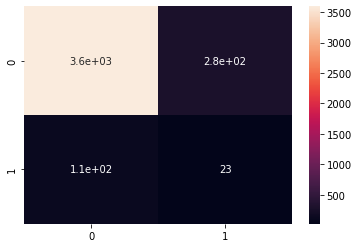

In [22]:
# Training
myModel.fit(X_train, Y_train) # y_train.ravel()

# Predicting
predictions = myModel.predict(x_val)
#predScores = myModel.predict_proba(x_val)

# Evaluation
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions)
recall = recall_score(y_val, predictions)
f1 = f1_score(y_val, predictions)
roc_auc = roc_auc_score(y_val, predictions)
f2 = 5*precision*recall / (4*precision+recall)

cm = confusion_matrix(y_val, predictions, labels=[0, 1])
#print(cm)
sns.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(y_val, predictions))

<b>Evaluation</b>

In [23]:
# # Training
# myModel.fit(x_train_val, y_train_val) # y_train.ravel()

# # Predicting
# predictions = myModel.predict(x_test)
# #predScores = myModel.predict_proba(x_test)

# # Evaluation
# accuracy = accuracy_score(y_test, predictions)
# precision = precision_score(y_test, predictions)
# recall = recall_score(y_test, predictions)
# f1 = f1_score(y_test, predictions)
# roc_auc = roc_auc_score(y_test, predictions)
# f2 = 5*precision*recall / (4*precision+recall)

# cm = confusion_matrix(y_test, predictions, labels=[0, 1])
# #print(cm)
# sns.heatmap(cm, annot=True)
# tn, fp, fn, tp = cm.ravel()

# print("TP=",tp)
# print("TN=",tn)
# print("FP=",fp)
# print("FN=",fn)

# print("Accuracy:%.2f%%"%(accuracy*100))
# print("Precision:%.2f%%"%(precision*100))
# print("Recall:%.2f%%"%(recall*100))
# print("F1 score:%.2f%%"%(f1*100))
# print("Roc_Auc score:%.2f%%"%(roc_auc*100))
# print("F2 score:%.2f%%"%(f2*100))
# print(classification_report(Y_test, predictions))